In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils.iterables import all_connectivities
from pathlib import Path

In [ ]:
df_pos = pd.read_csv(
    Path("edge_counts") / "blockwise_positive_schaefer200_thresholded.csv",
    index_col=0
).rename({"0": "edge_count"}, axis="columns")
df_neg = pd.read_csv(
    Path("edge_counts") / "blockwise_negative_schaefer200_thresholded.csv",
    index_col=0
).rename({"0": "edge_count"}, axis="columns")

block_sizes = pd.read_csv(
    "edge_counts/blockwise_block_size_schaefer200_thresholded.csv",
    index_col=0
).rename({"0": "edge_count"}, axis="columns")

In [ ]:
df = df_pos.copy()
df["edge_count"] = df_pos.edge_count - df_neg.edge_count
df["edge_count"] = df["edge_count"] / block_sizes.edge_count
df["sorted_pair"] = df.apply(lambda row: tuple(sorted([row['node_a'], row['node_b']])), axis=1)
df= df.drop_duplicates(subset=['sorted_pair', "cluster_label", "fold"])

In [ ]:
# We need reference from a meaningful baseline, so substract the median edge count of stable to the other classes
networks = df.node_a.unique()
stable_msk = (df.cluster_label == 0)
df_scaled = df.copy().loc[~stable_msk]
for net_a, net_b in all_connectivities(networks):
    ref_net_msk = (df.node_a == net_a) & (df.node_b == net_b)
    target_net_msk = (df_scaled.node_a == net_a) & (df_scaled.node_b == net_b)

    # All stable values across folds
    ref_values = df[ref_net_msk & stable_msk]["edge_count"]
    
    ref_value = np.quantile(ref_values, 0.5, method="closest_observation")

    df_scaled.loc[target_net_msk, "edge_count"] -= ref_value

df_scaled = df_scaled.set_index("sorted_pair")

Text(0.5, 1.0, 'Mann-Whitney pairwise comparisons')

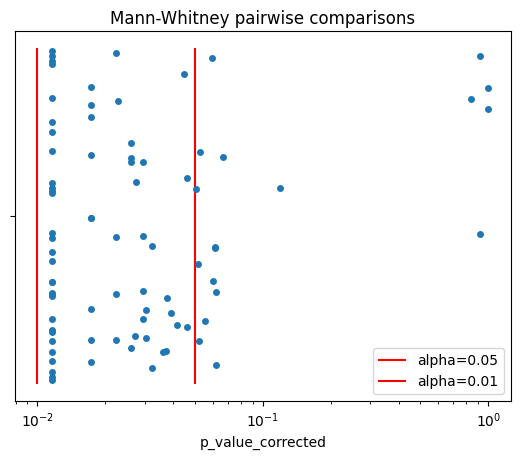

In [ ]:
from itertools import combinations
from scipy.stats import mannwhitneyu
import statsmodels.stats.multitest as smm

pairwise_results = []

comparisons = tuple(combinations(df.cluster_label.unique(), 2))

# Step 1: Collect all p-values globally
for pair, group in df.groupby('sorted_pair'):
    cluster_groups = {cl: sub['edge_count'].values for cl, sub in group.groupby('cluster_label')}
    
    for cl1, cl2 in comparisons:
        x = cluster_groups[cl1]
        y = cluster_groups[cl2]
        
        stat, p = mannwhitneyu(x, y, alternative='two-sided')

        pairwise_results.append({
            'sorted_pair': pair,
            'cluster1': cl1,
            'cluster2': cl2,
            'U_stat': stat,
            'p_value': p
        })

# Step 2: Global multiple testing correction
pairwise_df = pd.DataFrame(pairwise_results)
corrected_pvals = smm.multipletests(pairwise_df.loc[:, 'p_value'], method='bonferroni')[1]
pairwise_df.loc[:, 'p_value_corrected'] = corrected_pvals
sns.stripplot(pairwise_df, x="p_value_corrected")
plt.vlines([0.05], ymin=-0.1, ymax=0.1, colors="red", label="alpha=0.05")
plt.vlines([0.01], ymin=-0.1, ymax=0.1, colors="red", label="alpha=0.01")
plt.xscale("log")
plt.legend()
plt.title("Mann-Whitney pairwise comparisons")

In [ ]:
significant_df = pairwise_df[pairwise_df.p_value_corrected < 0.05]
significant_pairs = significant_df.sorted_pair.values.tolist()
significant_df = significant_df.set_index("sorted_pair")

In [ ]:
sub_df

,cluster1,cluster2,U_stat,p_value,p_value_corrected
sorted_pair,,,,,
"(Vis, Vis)",0,1,64.0,0.000205,0.017252
"(Vis, Vis)",0,2,64.0,0.000205,0.017252
"(Vis, Vis)",1,2,0.0,0.000138,0.011557


In [ ]:
df_scaled

,node_a,node_b,edge_count,cluster_label,fold,sorted_pair
0,Cont,Cont,-0.053333,1,0,"(Cont, Cont)"
1,Cont,Default,-0.013043,1,0,"(Cont, Default)"
2,Cont,DorsAttn,-0.021795,1,0,"(Cont, DorsAttn)"
3,Cont,Limbic,0.013889,1,0,"(Cont, Limbic)"
4,Cont,SalVentAttn,-0.031818,1,0,"(Cont, SalVentAttn)"
...,...,...,...,...,...,...
33,SalVentAttn,SomMot,-0.036364,2,7,"(SalVentAttn, SomMot)"
34,SalVentAttn,Vis,0.000000,2,7,"(SalVentAttn, Vis)"
40,SomMot,SomMot,-0.114286,2,7,"(SomMot, SomMot)"
41,SomMot,Vis,-0.027586,2,7,"(SomMot, Vis)"


In [ ]:
pairwise_df

,sorted_pair,cluster1,cluster2,U_stat,p_value,p_value_corrected
0,"(Cont, Cont)",0,1,64.0,0.000138,0.011557
1,"(Cont, Cont)",0,2,64.0,0.000138,0.011557
2,"(Cont, Cont)",1,2,0.0,0.000138,0.011557
3,"(Cont, Default)",0,1,64.0,0.000736,0.061811
4,"(Cont, Default)",0,2,60.0,0.001417,0.119069
...,...,...,...,...,...,...
79,"(SomMot, Vis)",0,2,64.0,0.000709,0.059518
80,"(SomMot, Vis)",1,2,0.0,0.000548,0.046022
81,"(Vis, Vis)",0,1,64.0,0.000205,0.017252
82,"(Vis, Vis)",0,2,64.0,0.000205,0.017252


In [ ]:
sub_df

,cluster1,cluster2,U_stat,p_value,p_value_corrected
sorted_pair,,,,,
"(Vis, Vis)",0,1,64.0,0.000205,0.017252
"(Vis, Vis)",0,2,64.0,0.000205,0.017252
"(Vis, Vis)",1,2,0.0,0.000138,0.011557


In [ ]:
grid = sns.FacetGrid(
    df_scaled,
    col="node_a",
    row="node_b",
    hue="cluster_label",
    palette=("tab:orange", "tab:green"),
    margin_titles=False,
    sharex=True,
    sharey=True,
    despine=False,
    height=2
)
grid.set_titles(
    template="{col_name}-{row_name}",
    row_template="{row_name}",
    col_template="{col_name}",
    color="tab:red", fontweight="roman", size="large"
)
grid.map_dataframe(sns.barplot, "cluster_label", "edge_count")
grid.set_xticklabels(("slow", "steep"))

grid.map(lambda **kwargs: plt.axhline(0, color="black", linestyle="--", linewidth=1))

for net_pair, ax in grid.axes_dict.items():

    sub_df = significant_df.query("index == @net_pair")
    if len(sub_df) == 0:
        continue
    for idx, row in sub_df.iterrows():
        pval = row.p_value_corrected
        if 0.01 <= pval < 0.05:
            annotation = "*"
            col = "black"
        elif 0.001 <=  pval < 0.01:
            annotation = "**"
            col = "black"
        elif pval <= 0.001:
            annotation = "***"
            col = "black"
        if row.cluster1 == 0:
            ax.text(x=row.cluster2 - 1, y=0.01, s=annotation)




KeyError: "None of ['sorted_pair'] are in the columns"